# How to run this notebook
`bazel build  HomographyComputation:jupyter && ./bazel-bin/HomographyComputation/jupyter`

# Homography computation
This notebook focuses on the problem of estimating 2D projectice transformations. In other words, we take as input two sets of point correspondances in the image plane, and compute the 3x3 matrix that transforms one set into the other.

Note: a 2D projective transformation has 8 degrees of freedom (it is defined up to a scale), therefore it requires at least 4 point correspondances.


## Direct methods

In [1]:
import numpy as np
import inspect
import timeit
import matplotlib.pyplot as plt
#%matplotlib notebook

norma = lambda x : x / x[:,None,2]
homo = lambda x : np.concatenate([x, np.ones((x.shape[0],1))], axis=1)

# Utilities for generating synthetic world and image points

In [3]:
# Creating test points
# Since we compute a homography, we create random points, project them on a plane, and then apply 
# a rotation and translation to them
# note: we can either move the plane or the camera

def create_planar_points(nbpoints, plane_normal, plane_distance):
    # Generate random points normally distributed in (-1, 1)
    points = 2 * (np.random.random((nbpoints, 3)) - 0.5)
    projected_points = points - (np.dot(plane_normal, points.T) + plane_distance)[:, None] * plane_normal
    return projected_points
    
    
# Plane normal and distance
n = np.array([0,-1,0])
d = 1
# Transformation to apply to the plane to obtain a new one
R = np.eye(3)
t = np.array([0,0,2])

projected_points = create_planar_points(1000, n, d)
transformed_projected_points = projected_points + t

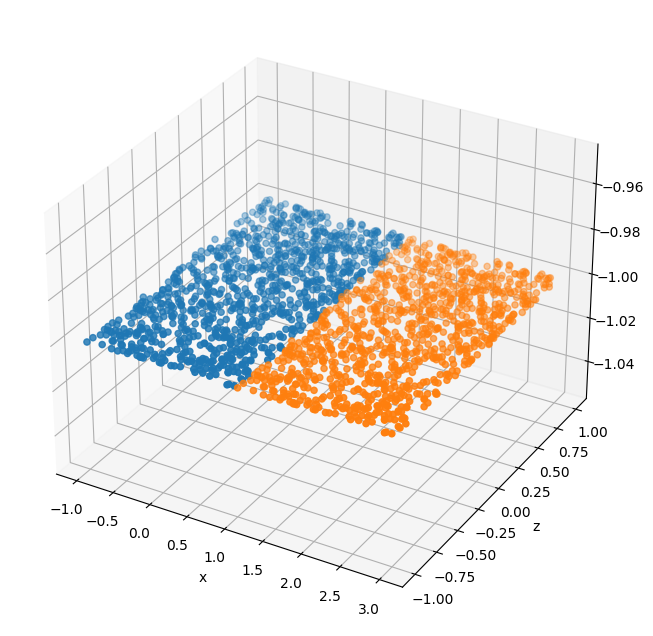

In [4]:
# Remark : we use camCV but matplotlib is in camISO, so we need to transform
camCV2camISO = lambda x:  (np.array([[ 0.,  0.,  1.], [-1.,  0.,  0.], [ 0., -1.,  0.]]) @ x.T).T

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(*camCV2camISO(projected_points).T)
ax.scatter(*camCV2camISO(transformed_projected_points).T)
plt.xlabel("x")
plt.ylabel("z")
plt.show()

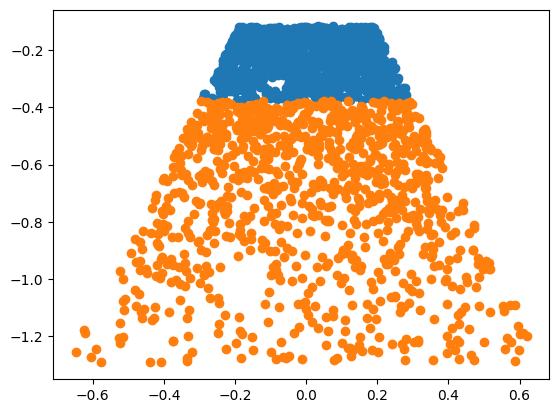

In [5]:
from scipy.spatial.transform import Rotation as Rot

def make_camera_matrix(pitch):
    K = np.eye(3) 
    # negative x angle = pitch down
    R = Rot.from_euler("x", pitch, degrees=True).as_matrix()
    # positive y = move camera up
    # positive z = move forward
    t = np.array([[0], [0],[-4]])
    RT = np.concatenate([R, t], axis = -1)
    P = K @ RT
    return P

def project_to_image(points3d, P):
    """
    Converts 3d points to homogeneous 3d points, applies the camera
    matrix to get 2d homogeneous points and returns the normalized points.
    """
    ppoints = (P @ homo(points3d).T).T
    ppoints = norma(ppoints)
    return ppoints

P = make_camera_matrix(-19)
image_pts1 = project_to_image(projected_points, P)[:, 0:2]
image_pts2 = project_to_image(transformed_projected_points, P)[:, 0:2]

plt.figure()
plt.scatter(*(image_pts1).T)
plt.scatter(*(image_pts2).T)
plt.show()

# Homography using the Direct Linear Transform
## Principle for the general homogeneous case
https://www.cs.cmu.edu/~16385/s17/Slides/10.2_2D_Alignment__DLT.pdf (Note: typo page 13)


Let's look first at a linear algorithm for a set of four 2D to 2D point correspondances $(x_i, x_i')$, in homogeneous coordinates. We  are looking for the 3x3 matrix $H | x_i' = Hx_i$.

Since we are working in homogeneous coordinates, equivalent 2d points can be represented by an ifinity of different 3-vectors that share the same direction. Therefore, from the previous equation, $x_i'$ and $Hx_i$ are actually not equal, they merely have the same direction. This leads us to the following expression using the cross-product: $$x_i \times Hx_i = 0$$.

From that relation, we derive a relation $A_ih = 0$, where $h$ is the $H$ matrix expressed as a column vector, and $A_i$ is a 3x9 matrix. From these two, only two are linearily independant, which lead us to the final expression

$$
\begin{bmatrix}
0^T & -\omega_i'\mathbf{x_i}^T & y_i'\mathbf{x_i}^T\\
w_i'\mathbf{x_i}^T & 0^T & -x_i'\mathbf{x_i}^T
\end{bmatrix}
\begin{pmatrix}
h^1 \\
h^2 \\
h^3
\end{pmatrix}
=0
$$
Remark:
- Bold represents the point as a 3-vector, normal thickness represents individual components from the homogeneous expression $\mathbf{x_i} = (x_i, y_i, w_i)$.
- $h^i$ is the ith row of $H$.
- Thus we get two equations, expressed in the 2x9 $A_i$ matrix, from one point correspondance $x_i, x_i'$. This equation holds for any homogeneous representation. It is common to choose $w_i = 1$, meaning that the points are in the image plane, but it is not necessary. 

### Solving for H: minimal case
From 4 correspondances, we get an 8x9 A matrix that forms the equation $Ah = 0$. We can then solve for a non-zero solution, since the trivial solution $h=0$ is irrelevant to us. 

### Solving for H: over determined case
If we have more than 4 correspondances, and there is noise in the measurements, then we cannot compute an exact solution appart from the zero solution, that we want to avoid.

Therefore we compute an approximate solution, by minimizing the norm $|Ah|$, and adding a constraint on the norm of $h$, such  as $|h| = 1$. The value itself doesn't matter, since $H$ is defined up to a scale.

The solution to such a problem is, equivalently:
- The unit eigenvector of $A^TA$ with the least eigenvalue.
- The unit singular vector correspoinding to the smallest singular value of $A$.

Therefore we solve the system of equations using an SVD.

TODO: read A5.3 p592

### Remark on normalization
The result of the DLT algorithm for computing 2D homographies depends on the coordinate frame in which the points are expressed. This suggests that some coordinate frames are better than others. We can transform our 2D homogeneous points into such a "good" frame through a normalization consisting of a translation and a scaling. The normalization should be carried out before the DLT algorithm, and then the homography matrix should be "un-normalized" by applying the inverse transform.

To go into further details, in the presence of noise, the normalization step is **required** for the DLT. This is because without it, some points in the image (those with higher coordinates) will have a significantly higher impact on the final result, which is not acceptable. 

In fact the normalization has two benefits:
- Improved accuracy, as stated above.
- Added invariance to arbitrary choices of scale and coordinates origin, since we choose a canonical coordinate frames to perform our computations in.


Remark: 
- It is an idea similar to the "normalized device coordinates" used in panorama computation, but here the use is even more motivated.
- The normalization should be re-computed for each different image / input points set.
- This normalization is sometimes called "pre-conditioning"

##### First: Translation
As a first step of normalization, the coordinates in each image are translated so as to bring the centroid of the set of all points to the origin. In homogeneous coordinates, the origin is $(0, 0, 1)$.

##### Second: Isotropic Scaling
Then the coordinates are scaled so that on average a point $u$ is of the form $u = (x, y, w)$ with $x, y, w$ having the same average magnitude. In practice we choose to scale so that the average distance of $u$ from the origin is equal to $\sqrt(2)$, which means that the average point is $(1, 1, 1)$.

Remark: 
- when talking about distance from origin, we do not count the homogeneous part, hence $\sqrt(2)$.
- the homogeneous points are assumed to be in the form $(x, y, 1)$.

In [4]:
from lib.Solvers import dlt
print(inspect.getsource(dlt.DLT))

def DLT(points_1, points_2):
    """
    Simple homography computation using the DLT.
    We minimise the norm ||Ah|| with |h| = 1, because
    ideally we want Ah=0.
    The solution is the unit singular vector corresponding
    to the smallest singular value of A.
    A: matrix with the point correspondance constraints (size 2N x 9)
        (N: number of point correspondances)
    h: homography coefficients (9 x 1)
    """
    assert len(points_1) == len(points_2)
    T = normalize(points_1)
    Tp = normalize(points_2)
    
    points_1 = norma(points_1 @ T.T)
    points_2 = norma(points_2 @ Tp.T)

    A = np.hstack([np.hstack([np.zeros_like(points_1), -points_1, points_1 * points_2[:,1][:,None]]),
           np.hstack([points_1, np.zeros_like(points_1), -points_1 * points_2[:,0][:,None]])]).reshape([-1,9])
    
    # 2. Compute SVD of A
    u, s, v = np.linalg.svd(A)
    # 3. Then h is the last column of v 
    H = v[-1, :].reshape(3, 3)
    H = np.linalg.inv(Tp) @ (H @ T)
    H = H

# Inhomogeneous case
We can turn the set of equations described above  into a set of inhomogeneous equations by imposing a condition $h_j = 1$ for some entry of $h$. This basically fixes the scale of $H$, and one can typically chose to fix the last element $H_{33}$ of $H$, ie $h_9$.

From this, we derive trivially, eseentially bring the last column of $A$ into the right hand side, since we fixed their $h_9$ coefficient, previously unknown, to 1.
$$
\begin{bmatrix}
0^T & -\omega_i'\mathbf{x_i}^T  & y_i'x_i & y_i'y_i\\
w_i'\mathbf{x_i}^T & 0^T & -x_i' x_i & -x_i'y_i
\end{bmatrix}
\tilde{h}
=\begin{pmatrix}
-y_i\omega_i\\
x_i\omega_i
\end{pmatrix}
$$
where $\tilde{h}$ is the first 8 elements of $H$, to which we must append 1 to make complete.


In [6]:
def LSTQ(image_pts1, image_pts2):
    n = len(image_pts1)
    M = np.hstack(
        (
            np.hstack((np.zeros((n, 3)), -image_pts1, -np.ones((n, 1)), (image_pts1.transpose(1,0) *  image_pts2[:,1]).transpose(1,0))),
            np.hstack((image_pts1, np.ones((n, 1)), np.zeros((n, 3)), -(image_pts1.transpose(1,0) *  image_pts2[:,0]).transpose(1,0)))
        )
    ).reshape((-1,8))
    
    b = np.vstack(
        (-image_pts2[:,1], image_pts2[:,0])     
    ).T.reshape((-1,1))
 
    if len(image_pts1) == 4:
        H = np.linalg.solve(M, b)
        
    else:
        H, residuals, rank, s = np.linalg.lstsq(M, b, rcond = None)
    
    H = np.append(H, [1]).reshape((3,3))
    return H


Random note: different ways of doing the same thing: multiply a matrix line-wise by a vector


- `np.einsum("ij, i -> ij", image_pts1, image_pts2[:,1])` is clearer but slow
- `image_pts1 * image_pts2[:,1][:, None]` forces us to create a faxe axis
- `(image_pts1.transpose(1,0) *  image_pts2[:,1]).transpose(1,0)` has none of these issues

# Iterative solution

# Experiments
1. Noise in 3d
2. Noise in 2d
3. Different camera movements (ex: pitch swipe that puts points on the horizon)

Measure speed / memory as well as errors.

## Rotating the plane
We measure the reprojection errors according to different pitch angles for the plane.
The goal is to test the stability of the algorithms around ambiguous regions (*possible candidates: points are almost colinear, some points are on the horizon at infinity*).

TODO:
- Complete with more movements, maybe also translation


In [10]:
errs = {
        "inhomogeneous": [],
        "homogeneous": []
       }

projected_points = create_planar_points(1000, n, d)
transformed_projected_points = projected_points + t

pitches = [x for x in np.arange(-90, 90, 0.5)]
for pitch in pitches:
    P = make_camera_matrix(pitch)
    image_pts1 = project_to_image(projected_points, P)[:, 0:2]
    image_pts2 = project_to_image(transformed_projected_points, P)[:, 0:2]
    
    H = LSTQ(image_pts1, image_pts2)
    errs["inhomogeneous"].append(np.sum(dlt.reproj_error(homo(image_pts1), homo(image_pts2), H)))
    
    H = dlt.DLT(homo(image_pts1), homo(image_pts2))
    errs["homogeneous"].append(np.sum(dlt.reproj_error(homo(image_pts1), homo(image_pts2), H)))
    

### Observations
- The DLT formulation is more stable. 

The peaks observed all around with the inhomogeneous solution are hard to explain. A generic explanation would be that this is the influence of points around infinity, or with outstanding values in general. The DLT formulation could deal with it them by scaling to 0.


- In both cases, we observe a peak at around 10 degrees. That is the case when the plane appears so flat in the image that the points are almost colinear (ie the camera is aligned with the plane)

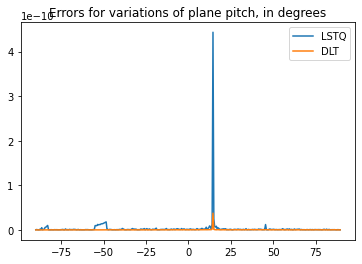

In [8]:
plt.figure()
plt.plot(pitches, errs["inhomogeneous"], label = "LSTQ")
plt.plot(pitches, errs["homogeneous"], label = "DLT")
plt.title("Errors for variations of plane pitch, in degrees")
plt.legend(loc = "upper right")
plt.show()

## Introducing noise in the image points
We add gaussian noise to the projected 2D points and observe how this affects the reprojection error.
Naturally, after injecting noise we cannot expect the reprojection error to be 0, as there exists no transformation that can perfectly match the points.

In [9]:
errs = {
        "inhomogeneous": [],
        "homogeneous": []
       }

sigmas = [x for x in np.arange(0, 0.3, 0.0002)]
pitch = 0

P = make_camera_matrix(pitch)
projected_points = create_planar_points(1000, n, d)
transformed_projected_points = projected_points + t
image_pts1 = project_to_image(projected_points, P)[:, 0:2]
image_pts2 = project_to_image(transformed_projected_points, P)[:, 0:2]

for sigma in sigmas:
    image_pts2_noise = image_pts2 + np.random.randn(*image_pts2.shape) * sigma
    
    H = LSTQ(image_pts1, image_pts2_noise)
    errs["inhomogeneous"].append(np.mean(reproj_error(homo(image_pts1), homo(image_pts2_noise), H)))
    
    H = DLT(homo(image_pts1), homo(image_pts2_noise))
    errs["homogeneous"].append(np.mean(reproj_error(homo(image_pts1), homo(image_pts2_noise), H)))

### Observation
The DLT formulation is more stable to noise.

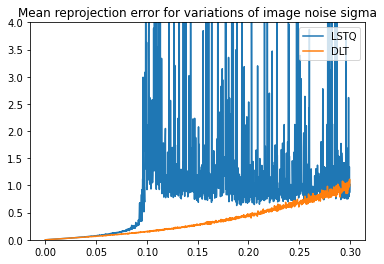

In [10]:
plt.figure()
plt.plot(sigmas, errs["inhomogeneous"], label = "LSTQ")
plt.plot(sigmas, errs["homogeneous"], label = "DLT")
plt.title("Mean reprojection error for variations of image noise sigma")
plt.legend(loc = "upper right")
plt.ylim(0,3)
plt.show()

## Wrong associations
We swap some points in the image point sets, so that they are incorrectly associated, and look at how this affects the reprojection error.

TODO:
- Instead of wrong associations, represent outliers with "strong" noise on top of the background noise as we did in the previous experiment.

In [12]:
errs = {
        "inhomogeneous": [],
        "homogeneous": []
       }

pitch = 0

P = make_camera_matrix(pitch)
projected_points = create_planar_points(1000, n, d)
transformed_projected_points = projected_points + t
image_pts1 = project_to_image(projected_points, P)[:, 0:2]
image_pts2 = project_to_image(transformed_projected_points, P)[:, 0:2]

swaps = [x for x in range(500)]
for swap in swaps:
    image_pts2_swapped = image_pts2.copy()
    np.random.shuffle(image_pts2_swapped[:swap])
    
    H = LSTQ(image_pts1, image_pts2_swapped)
    errs["inhomogeneous"].append(np.mean(reproj_error(homo(image_pts1), homo(image_pts2_swapped), H)))
    
    H = DLT(homo(image_pts1), homo(image_pts2_swapped))
    errs["homogeneous"].append(np.mean(reproj_error(homo(image_pts1), homo(image_pts2_swapped), H)))

### Observations
The DLT is more stable. However, when the number of outlier is high, is seems that the inhomogeneous case has a lower reprojection error, it reaches roughly the same asymptote as in the previous experiment. This could be meaningless however, as the qualitiy of the input points is so low that no useful homography can be computed anyways. 

Hypothesis: 
- The DLT diverges faster when the inputs are very bad if its last value approaches 0, then when we normalize the H matrix we divide it by a very small value.

TODO:
- Visually check the homography

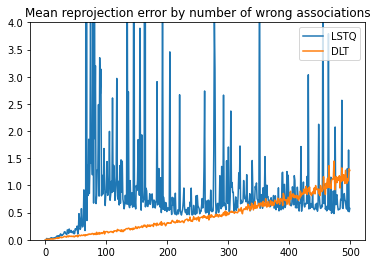

In [13]:
plt.figure()
plt.plot(swaps, errs["inhomogeneous"], label = "LSTQ")
plt.plot(swaps, errs["homogeneous"], label = "DLT")
plt.title("Mean reprojection error by number of wrong associations")
plt.legend(loc = "upper right")
plt.ylim(0,4)
plt.show()

## Runtime performance
We measure how long it takes to compute the homography depending on input size.

In [16]:
%%capture
errs = {
        "inhomogeneous": [],
        "homogeneous": []
       }

sizes = [x for x in range(4, 1000, 10)]
pitch = 0

P = make_camera_matrix(pitch)
t = np.array([0,0,2])
n = np.array([0,-1,0])

for size in sizes:
    projected_points = create_planar_points(size, n, d)
    transformed_projected_points = projected_points + t
    image_pts1 = project_to_image(projected_points, P)[:, 0:2]
    image_pts2 = project_to_image(transformed_projected_points, P)[:, 0:2]

    func_time = %timeit -o  LSTQ(image_pts1, image_pts2)
    errs["inhomogeneous"].append(np.mean(func_time.all_runs))
    
    h1 = homo(image_pts1)
    h2 = homo(image_pts2)
    func_time = %timeit -o  DLT(h1, h2)
    errs["homogeneous"].append(np.mean(func_time.all_runs))

### Observation
This is not very meaningful without knowing the types of optimizations numpy uses.

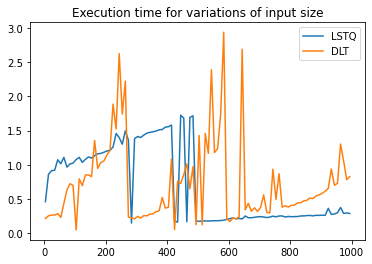

In [17]:
plt.figure()
plt.plot(sizes, errs["inhomogeneous"], label = "LSTQ")
plt.plot(sizes, errs["homogeneous"], label = "DLT")
plt.title("Execution time for variations of input size")
plt.legend(loc = "upper right")
plt.show()

# Conclusions
Pros of DLT
- More stable (why?)

Cons of DLT
- Requires more memory
- Requires a DLT, including in the minimal case (right?)

Pros of LSTQ:
- Does not require normalization
- The minimal case can be solved by gaussian elimination